In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn, optim
import time
from torch.utils.data import Dataset, DataLoader
import torch
#set output path for trained data:
PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'

# trackML challenge 

This notebook used to train the model

The inputs are loaded from `/scratch/pitt/trackML/train_graphs` folder, this can be changed

If running on GPU, run the following cell:


In [4]:
use_cuda = torch.cuda.is_available()
print('Availability of CUDA:',use_cuda)
if use_cuda: torch_ft = torch.cuda.FloatTensor
else: torch_ft = torch.FloatTensor
device = torch.device("cuda:1" if use_cuda else "cpu")
torch.cuda.set_device(1)
idevice = torch.cuda.current_device()
print('Will work on device number',idevice,', named: ',torch.cuda.get_device_name(idevice))
torch.backends.cudnn.benchmark = True
print('device = ',device)

Availability of CUDA: True
Will work on device number 1 , named:  TITAN V
device =  cuda:1


# Dataloader:

dataloader reads files and construct inputs

In [5]:
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Is', 'y'])

def load_graph(filename):
    #print('loading',filename)
    with np.load(filename) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Is, y):
    return Graph(X, Is, y)

class trackDataLoader(Dataset):
    def __init__(self, filenames, n_samples=None):
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)

def collate_fn(graphs):

    batch_size = len(graphs)
    
    if batch_size == 1:
        g = graphs[0]
        
        batch_target = g.y
        batch_inputs = [torch_ft(g.X), g.Is]
        
        return batch_inputs, batch_target
    
    #construct batches
    batch_X=[]; batch_Is=[]; batch_target=[]
    n_hits = 0
    for i, g in enumerate(graphs):
        batch_target.append(g.y)
        batch_X.append(g.X)
        batch_Is.append(g.Is + n_hits)
        n_hits += g.X.shape[0]
    batch_X = np.concatenate(batch_X)
    batch_Is = np.concatenate(batch_Is)
    batch_target = np.concatenate(batch_target)
    
    batch_inputs = [torch_ft(batch_X), batch_Is]
    
    return batch_inputs, batch_target


Read files, in total we have 50 files. Keep a single file for validation, and the rest for the training:

In [38]:
from glob import glob
train_files = glob('/scratch/pitt/trackML/graph_full_6var_250MeV_150mmz0_1eta/*')
test_files, train_files = train_files[:40], train_files[40:]
train_dataset = trackDataLoader(train_files) #use 1 file , n_samples = 1
train_loader = DataLoader(train_dataset, collate_fn=collate_fn, num_workers = 0)
test_dataset = trackDataLoader(test_files, 1) #test_file train_files
test_loader = DataLoader(test_dataset, batch_size = len(test_files), collate_fn=collate_fn)
print('available for training',len(train_files),' for testing',len(test_files))

available for training 176  for testing 40


## Trainer

In [7]:
def CreateCash(model):
    cache={}
    for c in (['loss']+['val_loss']+[*model.state_dict().keys()]):
        cache[c]=[]
    return cache

def get_inputs(X, Is, device):

    n_hits = X.shape[0]
    n_edges = Is.shape[0]
    edge_idx = np.arange(n_edges)
    Ri = torch.sparse.FloatTensor(torch.LongTensor([Is[:,1],edge_idx]),
                        torch.ones(n_edges),
                        torch.Size([n_hits,n_edges]))
    Ro = torch.sparse.FloatTensor(torch.LongTensor([Is[:,0],edge_idx]),
                        torch.ones(n_edges),
                        torch.Size([n_hits,n_edges]))
    
    if 'cuda'==device.type: return [X, Ro.to(device), Ri.to(device)]  
    return [X, Ro, Ri]

def get_batch_weights(batch_target, weighted, pretrain):
    if(weighted):
        frac_connected_edges = batch_target.sum()/batch_target.shape[0]
        batch_weights_real = batch_target * (1.0 - frac_connected_edges)
        batch_weights_fake = (1 - batch_target) * frac_connected_edges
        batch_weights = batch_weights_real + batch_weights_fake
    else:
        batch_weights_real = batch_target
        batch_weights_fake = (1 - batch_target)
        batch_weights = batch_weights_real + batch_weights_fake
        
    if not pretrain:
        batch_weights = batch_weights_real*(1 - frac_connected_edges) + batch_weights_fake
    
    return batch_weights
 
def train(data_loader, model, optimizer, criterion, epochs=1, 
          cache={'loss':[]}, device=torch.device("cpu"), 
          pretrain=None, weighted = False, validation_set = None):
    
    print('len of cache is = ',len(cache['loss']))
    isGPU = torch.cuda.is_available() and 'cuda'==device.type
    if isGPU and not next(model.parameters()).is_cuda:
        print('copy the model to GPU')
        model.to(device)
    tic = time.time()
    for epoch in range(epochs):
        for i, (batch_input, batch_target) in enumerate(data_loader):
            
            #training performed in two steps, once on the full data, remove back edges bellow the threshold
            #then train again (with pretrain=pretrained model)
            threshold = 0.2
            
            X, Is = batch_input
            batch_input = get_inputs(X, Is, device)

            batch_target = torch_ft(batch_target)

            if pretrain:
                pretrain.eval()
                with torch.no_grad():
                    e = torch.sigmoid(pretrain(batch_input))
                    
                #filter inputs
                mask_edges = ((e + batch_target) > threshold).nonzero().squeeze().cpu()
                Is_filter = Is[mask_edges]
                e = e[mask_edges]
                batch_target = batch_target[mask_edges]
                batch_input = get_inputs(X, Is_filter, device)
                batch_input.append(e)
                
                #batch_weights = batch_target + (1 - batch_target)

            batch_weights = get_batch_weights(batch_target, weighted, pretrain)
            
            #evaluate the model, and compute the gradients
            batch_output = model(batch_input)
            loss=criterion(batch_output, batch_target, weight=batch_weights)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        cache['loss'].append(loss.item())
        #evaluate validation loss:
        if validation_set:
            with torch.no_grad():
                test_inputs, test_target = next(iter(test_loader))
                test_X, test_Is = test_inputs
                test_inputs = get_inputs(test_X, test_Is, device)
                test_target = torch_ft(test_target)
                
                if pretrain:
                    test_e = torch.sigmoid(pretrain(test_inputs))

                    #filter first training:
                    test_mask_edges = (test_e > threshold).nonzero().squeeze().cpu()
                    Is_filter = test_Is[test_mask_edges]
                    test_e = test_e[test_mask_edges]
                    test_target = test_target[test_mask_edges]
                    test_inputs = get_inputs(test_X, Is_filter, device)
                    test_inputs.append(test_e)
                    
                test_weights = get_batch_weights(test_target, weighted, pretrain)
    
                #evaluate
                test_pred = model(test_inputs)
                vloss = criterion(test_pred, test_target, weight=test_weights)
                cache['val_loss'].append(vloss.item())
                
            printProgressBar(epoch, epochs, [loss.item(),vloss.item()])
        else: printProgressBar(epoch, epochs, [loss.item()])
    toc = time.time()
    print('total time: %2.2f sec' %(toc-tic))
    return cache

def printProgressBar (iteration, total, losses = [], decimals = 1, length = 50):
    total = total - 1 #since usually we start from 0 till n-1
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = '#' * filledLength + '-' * (length - filledLength)
    if len(losses)==1:
        print('\rprogress |%s| %s%% loss - %s' % (bar, percent, str(losses[0])), end = '\r')
    else:
        print('\rprogress |%s| %s%% loss - %2.5f | validation - %2.5f' % 
              (bar, percent, float(losses[0]), float(losses[1])), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

# Model parameters, and training

model, criterion and optimizer. using `nn.functional` to define "weighted loss"

Define function to visualize the results

In [8]:
import sklearn.metrics
def AnalyzeThreshold(test_pred, test_target, log=True):
    thresh=0.5
    y_true = (test_target > thresh)
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)
    
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

    # Plot the model outputs
    binning=dict(bins=50, range=(0,1), histtype='bar', log=log)
    ax0.hist(test_pred[test_target<thresh], label='fake', **binning, alpha=0.7)
    ax0.hist(test_pred[test_target>thresh], label='true', **binning, alpha=0.7)
    ax0.set_xlabel('Model output')
    ax0.legend(loc=0)

    # Plot the ROC curve
    auc = sklearn.metrics.auc(fpr, tpr)
    ax1.plot(fpr, tpr)
    ax1.plot([0, 1], [0, 1], '--')
    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate')
    ax1.set_title('ROC curve, AUC = %.3f' % auc)

    plt.tight_layout()

## first training 

train a simple NN to reject bad edges, to speed up the training of GNN

In [9]:
class PreTrainModel(nn.Module):
    def __init__(self, input_dim=6, hidden_features=40, hidden_activation=nn.Tanh):
        super(PreTrainModel, self).__init__()
        
        self.network1 = nn.Sequential(
            nn.Linear(input_dim, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),            
            hidden_activation())
                
        self.network2 = nn.Sequential(
            nn.Linear(input_dim + hidden_features, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),   
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),            
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation())
        
        self.network3 = nn.Sequential(
            nn.Linear(input_dim + 2*hidden_features, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features//2, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features//2, hidden_features//4, bias=True),
            hidden_activation(),            
            nn.Linear(hidden_features//4, 1, bias=False))
        
        
    def forward(self, inputs):
        X, Ro, Ri = inputs
        
        #combine two nodes to construct edge:
        bo = Ro.transpose(0,1).mm(X)
        bi = Ri.transpose(0,1).mm(X)
        E = bo - bi
        
        #reshape input parameters:
        ReshapeEdges(E)
        
        E1 = self.network1(E)
        E2 = self.network2(torch.cat([E1, E], dim=-1))
        e = self.network3(torch.cat([E1, E2, E], dim=-1))
        return e.squeeze(-1) 

def ReshapeEdges(E):
    E[:,0] = E[:,0]/1300
    E[:,1] = E[:,1]/1300
    E[:,2] = E[:,2]/250
    E[:,3] = torch.acos(torch.cos(E[:,3]))/1.57
    E[:,4] = torch.abs(E[:,4])/2.0
    E[:,5] = -E[:,5]/210.0

In [ ]:
model1 = PreTrainModel(hidden_features=32)
cache1 = CreateCash(model1)
#model1.to(device)
criterion1 = getattr(nn.functional, 'binary_cross_entropy_with_logits')
optimizer1 = optim.Adam(model1.parameters(), lr = 0.05)


In [ ]:
for param_group in optimizer1.param_groups:
    param_group['lr'] = 0.0005

In [ ]:
cache = train(train_loader, model1, optimizer1, criterion1, 500, 
              cache1, weighted = True, device = device, validation_set = test_loader)
plt.plot(cache['loss'],label='training loss')
plt.plot(cache['val_loss'],label='validation loss')
plt.legend(); plt.show() 
torch.save(model1.state_dict(), PATH+'weights_pretrain2.pt')
torch.save({
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': optimizer1.state_dict(),
    'cache': cache1,
}, PATH+'training_pretrain2.pt')

In [ ]:
torch.save(model1.state_dict(), PATH+'weights_pretrain.pt')
torch.save({
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': optimizer1.state_dict(),
    'cache': cache1,
}, PATH+'training_pretrain.pt')

Check training results

In [ ]:
%%time
test_dataset = trackDataLoader(test_files, 1) #test_files train_files
test_loader = DataLoader(test_dataset, batch_size = len(test_files), collate_fn=collate_fn)
with torch.no_grad():
    test_pred, test_target = next(iter(test_loader))
    X, Is = test_pred
    test_pred = get_inputs(X, Is, device)
    test_pred = model1(test_pred)
    test_pred = torch.sigmoid(test_pred)
    test_target = torch.FloatTensor(test_target)
AnalyzeThreshold(test_pred.cpu(), test_target, log=True)


In [ ]:
threshold = 0.05
print('signal eff = %2.2f%%'%(test_target[test_pred>threshold].sum()/test_target[test_pred>-1].sum()*100))
print('edge filtering = %2.2f%%'%(100*(test_pred>0.5).nonzero().shape[0]/test_pred.shape[0]))
print(test_pred.shape[0],' -> ',(test_pred>0.5).nonzero().shape[0])

Save weights for the first model, before training the second model (GNN)

In [ ]:
PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'
torch.save(model1.state_dict(), PATH+'weights_pretrain.pt')
torch.save({
    'model_state_dict': model1.state_dict(),
    'optimizer_state_dict': optimizer1.state_dict(),
    'cache': cache1,
}, PATH+'training_pretrain.pt')

Load weights

In [10]:
PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'
model1 = PreTrainModel(hidden_features=32)
criterion1 = getattr(nn.functional, 'binary_cross_entropy_with_logits')
optimizer1 = optim.Adam(model1.parameters(), lr = 0.05)

checkpoint = torch.load(PATH+'training_pretrain.pt')
model1.load_state_dict(checkpoint['model_state_dict'])
model1.to(device)
optimizer1.load_state_dict(checkpoint['optimizer_state_dict'])
cache1 = checkpoint['cache']


## Second training

Once we have first training on the edges, we can reject the edges to reduce the size of the events. The node inputs remaing the same, while the $I_S$ index matrix will be reduced, to keep only fake edges that have get high weights during the first training

In [29]:
class EdgeClasification(nn.Module):
    def __init__(self, input_dim, hidden_features, hidden_activation=nn.Tanh):
        super(EdgeClasification, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim * 3, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features//2, bias=True),            
            hidden_activation(),
            nn.Linear(hidden_features//2, hidden_features//4, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features//4, 1, bias=True),
            nn.Sigmoid())
        
    def forward(self, H, Ro, Ri, e):
        eH = e[:,None]*H
        Ho = Ri.transpose(0,1).mm(Ro.mm(eH))
        Hi = Ro.transpose(0,1).mm(Ri.mm(eH))
        return self.network(torch.cat([Ho, H, Hi], dim=1))
        #return self.network(H)

class EdgeRepresentation(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_features, hidden_activation=nn.Tanh):
        super(EdgeRepresentation, self).__init__()
        self.network1 = nn.Sequential(
            nn.Linear(input_dim, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation())
        
        self.network2 = nn.Sequential(
            nn.Linear(input_dim + hidden_features, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features, bias=True),
            hidden_activation())
               
        self.network3 = nn.Sequential(
            nn.Linear(input_dim + 2*hidden_features, hidden_features, bias=False),
            hidden_activation(),
            nn.Linear(hidden_features, hidden_features//2, bias=True),
            hidden_activation(),
            nn.Linear(hidden_features//2, edge_dim, bias=False),
            hidden_activation())
        
    def forward(self, E):
        H1 = self.network1(E)
        H2 = self.network2(torch.cat([H1, E], dim=-1))
        return self.network3(torch.cat([H1, H2, E], dim=-1))

class GNNmodel(nn.Module):
    def __init__(self, input_dim=6, edge_dim = 8, hidden_dim=40, niter=2, hidden_activation=nn.Tanh):
        super(GNNmodel, self).__init__()
        
        self.edge_repr = EdgeRepresentation(input_dim, edge_dim, hidden_dim, hidden_activation)
                             
        self.clasifier = EdgeClasification(edge_dim, hidden_dim, hidden_activation)
               
        self.niter = niter
                
    def forward(self, inputs):
        X, Ro, Ri, w = inputs
        
        #combine two nodes to construct edge:
        bo = Ro.transpose(0,1).mm(X)
        bi = Ri.transpose(0,1).mm(X)
        E = bo - bi
        ReshapeEdges(E)
        
        H = self.edge_repr(E)
            
        # evaluate edge weight
        for i in range(self.niter):
            e = self.clasifier(H, Ro, Ri, w)
        
        # learn from neighbours
        #e = self.clasifier(H, Ro, Ri, e) 
        #optimize future training for high edge weights only
        
        return e.squeeze(-1) 
    

In [30]:
model = GNNmodel(edge_dim = 16, hidden_dim = 32, niter = 2)
cache = CreateCash(model)
criterion = getattr(nn.functional, 'binary_cross_entropy')
optimizer = optim.Adam(model.parameters(), lr = 0.01)
#device=torch.device("cpu") #change to cuda if available

train model

len of cache is =  0
copy the model to GPU
progress |##################################################| 100.0% loss - 0.05450 | validation - 0.06429
total time: 7360.37 sec


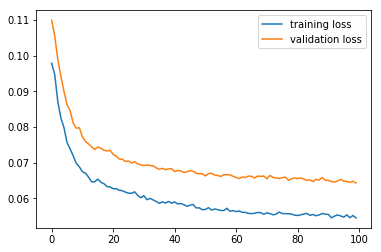

In [32]:
cache = train(train_loader, model, optimizer, criterion, 100,
              cache, weighted = True, device = device, pretrain = model1, validation_set = test_loader)
plt.plot(cache['loss'],label='training loss')
plt.plot(cache['val_loss'],label='validation loss')
plt.legend(); plt.show() 
torch.save(model.state_dict(), PATH+'weights_gnn_filtered2.pt')

To train more the model, we can change the learning rate

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001

In [ ]:
cache = train(train_loader, model, optimizer, criterion, 5,
              cache, weighted = True, device = device, pretrain = model1, validation_set = test_loader)
plt.plot(cache['loss'],label='training loss')
plt.plot(cache['val_loss'],label='validation loss')
plt.legend(); plt.show() 

PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'
torch.save(model.state_dict(), PATH+'weights_gnn_filtered2.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'cache': cache,
}, PATH+'training_gnn_filtered2.pt')

Check model performance

CPU times: user 11.2 s, sys: 80 ms, total: 11.3 s
Wall time: 787 ms


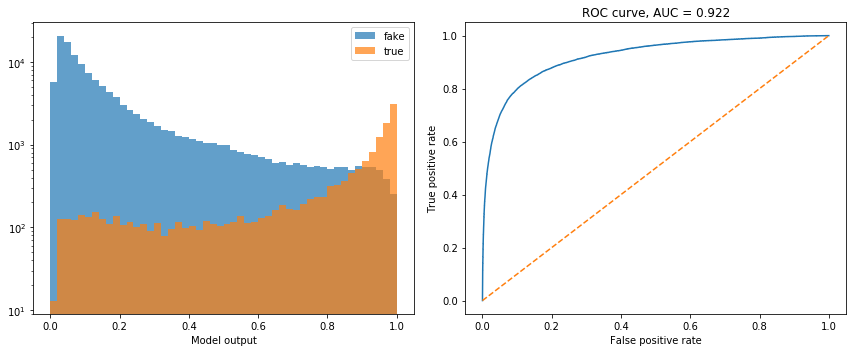

In [33]:
%%time
#test_dataset = trackDataLoader(test_file, 1) #test_file train_files
#test_loader = DataLoader(test_dataset, batch_size = len(test_file), collate_fn=collate_fn)
with torch.no_grad():
    inputs, test_target = next(iter(test_loader))
    X, Is = inputs
    inputs = get_inputs(X, Is, device)
    e = torch.sigmoid(model1(inputs))
    
    #filter first training:
    mask_edges = (e > 0.2).nonzero().squeeze().cpu()
    Is_filter = Is[mask_edges]
    e = e[mask_edges]
    test_target = test_target[mask_edges]
    inputs = get_inputs(X, Is_filter, device)
    inputs.append(e)
    
    #evaluate
    test_pred = model(inputs)
    test_target = torch.FloatTensor(test_target)
AnalyzeThreshold(test_pred.cpu(), test_target, log=True)


Save the trained model:

In [34]:
PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'
torch.save(model.state_dict(), PATH+'weights_gnn_filtered2.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'cache': cache,
}, PATH+'training_gnn_filtered2.pt')

Load weights, and continue training

In [ ]:
PATH = '/mnt/lustre/agrp/pitt/ML/trackML/sample_code_submission/GraphBuilder/data/'
model = GNNmodel(edge_dim = 16, hidden_dim=32)
criterion = getattr(nn.functional, 'binary_cross_entropy')
optimizer = optim.Adam(model.parameters(), lr = 0.01)

checkpoint = torch.load(PATH+'training_gnn_filtered2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
cache = checkpoint['cache']
next(model.parameters()).is_cuda

# Code performance

evaluate accuracy of the predictions using the submission code:

In [ ]:
# need to be done in a docker
# from trackml.score import score_event
# copy the weights to the GraphBuilder/data folder and run ./run.sh from sample_code_submission

### Full model validation checks
Draw the weights of the model and a ROC curve.

Check the results for full data (also available in [eval_model_filter](eval_model_filter.ipynb) notebook):

In [35]:
%%time
#test_dataset = trackDataLoader(test_files, 1) #test_file train_files
#test_loader = DataLoader(test_dataset, batch_size = len(test_file), collate_fn=collate_fn)
with torch.no_grad():
    inputs, test_target = next(iter(test_loader))
    X, Is = inputs
    inputs = get_inputs(X, Is, device)
    e = torch.sigmoid(model1(inputs))
    
    #filter first training:
    mask_edges = (e > 0.2).nonzero().squeeze().cpu()
    Is_filter = Is[mask_edges]
    e_masked = e[mask_edges]
    test_target_masked = test_target[mask_edges]
    inputs = get_inputs(X, Is_filter, device)
    inputs.append(e_masked)
    
    #evaluate second round, and append to the first predictions
    test_pred_masked = model(inputs)
    test_pred[mask_edges] = test_pred_masked
    
    test_target = torch.FloatTensor(test_target)
AnalyzeThreshold(test_pred.cpu(), test_target, log=True)


RuntimeError: CUDA error: device-side assert triggered

In [36]:
cut_edge_weight = 0.9
print('total stats: %d good and %d fake edges'%(test_target.sum(),(test_target==0).sum()))
print('signal eff = %2.2f%% are above threshold'
      %(test_target[test_pred>cut_edge_weight].sum()/test_target[test_pred>-1].sum()*100))
print('signal purity = above the threshold %2.2f%% are truth edges'
      %(test_target[test_pred>cut_edge_weight].sum()/(test_pred>cut_edge_weight).sum()*100))


total stats: 15030 good and 307436 fake edges


RuntimeError: cuda runtime error (59) : device-side assert triggered at /mnt/lustre/agrp/pitt/ML/pytorch/aten/src/THC/THCTensorMathCompare.cuh:82